# Exploritary Data Analysis for the jobs dataset
only the jobs which match to some candidates

## Import libraries

In [1]:
import re
import json
import pymorphy3
import tokenize_uk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Load data

In [2]:
df = pd.read_csv('../../data/prepared_jobs/jobs_prepared.csv')
df.head()

Position                                   Long Description  \
0  1c developer  –ö–æ–º–ø–∞–Ω—ñ—è  —Å–ø—ñ–≤–ø—Ä–∞—Ü—é—î –∑ —Ç–∞–∫–∏–º–∏ –ª—ñ–¥–µ—Ä–∞–º–∏ —Ñ–∞—Ä–º–∞ —ñ...   
1  1C developer  IT –∫–æ–º–ø–∞–Ω—ñ—è ‚Äú–ù–æ–≤–∞ –ü–æ—à—Ç–∞ –î—ñ–¥–∂–∏—Ç–∞–ª‚Äù, —â–æ –≤—Ö–æ–¥–∏—Ç—å ...   
2  1C developer  –í–∏–º–æ–≥–∏ –¥–æ —É—Å–ø—ñ—à–Ω–æ–≥–æ –∫–∞–Ω–¥–∏–¥–∞—Ç–∞:\r\n‚Äî –ü—Ä–æ–≥—Ä–∞–º—ñ—Å—Ç...   
3  1C developer  –û–ö–ö–û –∑–∞–ø—Ä–æ—à—É—î —Å—Ç–∞—Ç–∏ —á–∞—Å—Ç–∏–Ω–æ—é –ø–æ—Ç—É–∂–Ω–æ—ó –∫–æ–º–∞–Ω–¥–∏ ...   
4  1C Developer  **Everad** ‚Äî –º—ñ–∂–Ω–∞—Ä–æ–¥–Ω–∞ CPA-–º–µ—Ä–µ–∂–∞ –∑ –ø—Ä—è–º–∏–º —Ä–µ...   

          Company Name Exp Years Primary Keyword English Level  \
0              AboutHR        2y           Other           NaN   
1  Nova Poshta Digital        3y           Other           NaN   
2             Zakaz.ua        3y           Other           NaN   
3           OKKO Group        3y           Other           NaN   
4               Everad        3y           Other           NaN   

                   Published Long Description_lang  \
0  2021-06-01T00:00:00+03:00                    uk   
1  2023-03-01T00:00:00+02:00                    uk   
2  2022-02-01T00:00:00+02:00                    uk   
3  2021-07-01T00:00:00+03:00                    uk   
4  2023-04-01T00:00:00+03:00                    uk   

                                     id  
0  0e8d1ddb-b002-53c2-a761-20406026f153  
1  3f65951b-c5c3-5472-a39b-6bbf516addc1  
2  741d9555-9324-54ca-af5b-de4887b0f978  
3  5002f118-575e-5325-83c5-8075e5554bdf  
4  70a9a45b-302f-59a5-a4e1-ee0da427a5f1

In [3]:
# unique_jobs = list(json.load(open('../../data/final_groups/groups.json')).values())
# unique_jobs =list(set([job for jobs in unique_jobs for job in jobs]))
# print("Unique jobs count:",len(unique_jobs))

Unique jobs count: 60940


In [3]:
# df = df[df['id'].isin(unique_jobs)].reset_index(drop=True)
# print("Jobs count after filtering:",len(df['id'].unique()))
# df.head()

## General dataset statistics

In [4]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169358 entries, 0 to 169357
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Position               169358 non-null  object
 1   Long Description       169358 non-null  object
 2   Company Name           169358 non-null  object
 3   Exp Years              169358 non-null  object
 4   Primary Keyword        169358 non-null  object
 5   English Level          152212 non-null  object
 6   Published              169358 non-null  object
 7   Long Description_lang  169358 non-null  object
 8   id                     169358 non-null  object
dtypes: object(9)
memory usage: 11.6+ MB


In [5]:
# unique values counts for each column
for col in df.columns:
    print(col,'\t', len(df[col].unique()))

Position 	 82423
Long Description 	 169358
Company Name 	 12897
Exp Years 	 5
Primary Keyword 	 46
English Level 	 6
Published 	 45
Long Description_lang 	 2
id 	 169358


In [6]:
# general statistics
df.describe()

Position                                   Long Description  \
count            169358                                             169358   
unique            82423                                             169358   
top     DevOps Engineer  –ö–æ–º–ø–∞–Ω—ñ—è  —Å–ø—ñ–≤–ø—Ä–∞—Ü—é—î –∑ —Ç–∞–∫–∏–º–∏ –ª—ñ–¥–µ—Ä–∞–º–∏ —Ñ–∞—Ä–º–∞ —ñ...   
freq               1759                                                  1   

       Company Name Exp Years Primary Keyword English Level  \
count        169358    169358          169358        152212   
unique        12897         5              46             5   
top     GlobalLogic        3y      JavaScript         upper   
freq           4600     55971           20211         72828   

                        Published Long Description_lang  \
count                      169358                169358   
unique                         45                     2   
top     2022-01-01T00:00:00+02:00                    en   
freq                         6357                141897   

                                          id  
count                                 169358  
unique                                169358  
top     0e8d1ddb-b002-53c2-a761-20406026f153  
freq                                       1

## Additional function

In [7]:
def hist_with_stat_line(df, col, title):
    df[col].str.len().plot(kind= 'hist',bins=100, figsize=(15,5), color='green', alpha=0.5, title=title)
    plt.axvline(df[col].str.len().median(), color='red', linestyle='dashed', linewidth=1, label='median')
    plt.axvline(df[col].str.len().quantile(0.25), color='black', linestyle='dashed', linewidth=1, label='25%')
    plt.axvline(df[col].str.len().quantile(0.75), color='black', linestyle='dashed', linewidth=1, label='75%')
    plt.axvline(df[col].str.len().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean')
    plt.legend()
    plt.show()

## Statistics and plots for each column

### Position column
`manual written position titles`

In [8]:
# min, max, mean, median, 25%, 50%, 75% for length of Position column
df['Position'].str.len().describe()

count    169358.000000
mean         26.829580
std          12.895344
min           2.000000
25%          18.000000
50%          24.000000
75%          33.000000
max         215.000000
Name: Position, dtype: float64

<Axes: title={'center': 'Top 20 most popular positions'}, xlabel='Position'>

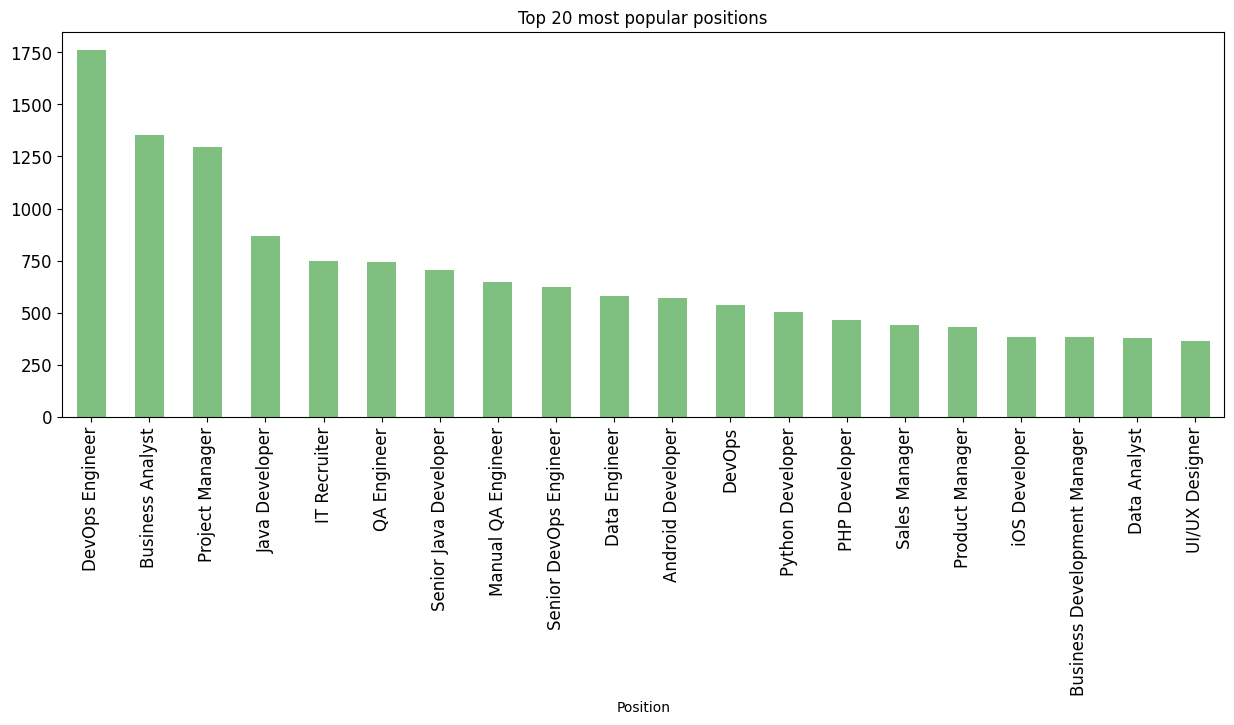

In [9]:
# top 20 most popular positions as a bar chart
df['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions', 
                                        fontsize=12, color='green', alpha=0.5)


In [10]:
# tail 20 positions
df['Position'].value_counts()[-20:]

Position
Frontend developer experienced in React                       1
Front End Developer for AI Startup                            1
Front-End Developer for a new website product                 1
Front End Developer for DataMarx                              1
Front End Developer for Ciklum                                1
Front End Developer for Cutting Edge AR product company       1
Frontend developer for Crypto project                         1
Front-End Developer for Continuity2                           1
Front-end developer for Commerce cloud consulting team        1
Front-End Developer for CleanMyMac                            1
Front End Developer for Ciklum (Cellebrite)                   1
Front-end Developer for CCTV Video Management Platform        1
Frontend Developer for Annut                                  1
Front-End Developer for Business Intelligence Project         1
Frontend Developer for big client project                     1
Front-end developer for a San F

we can see that the most common position and some of the rarest positions can be really similar due to manual writing of the position titles.

<Axes: title={'center': 'Top 20 most popular positions. English language'}, xlabel='Position'>

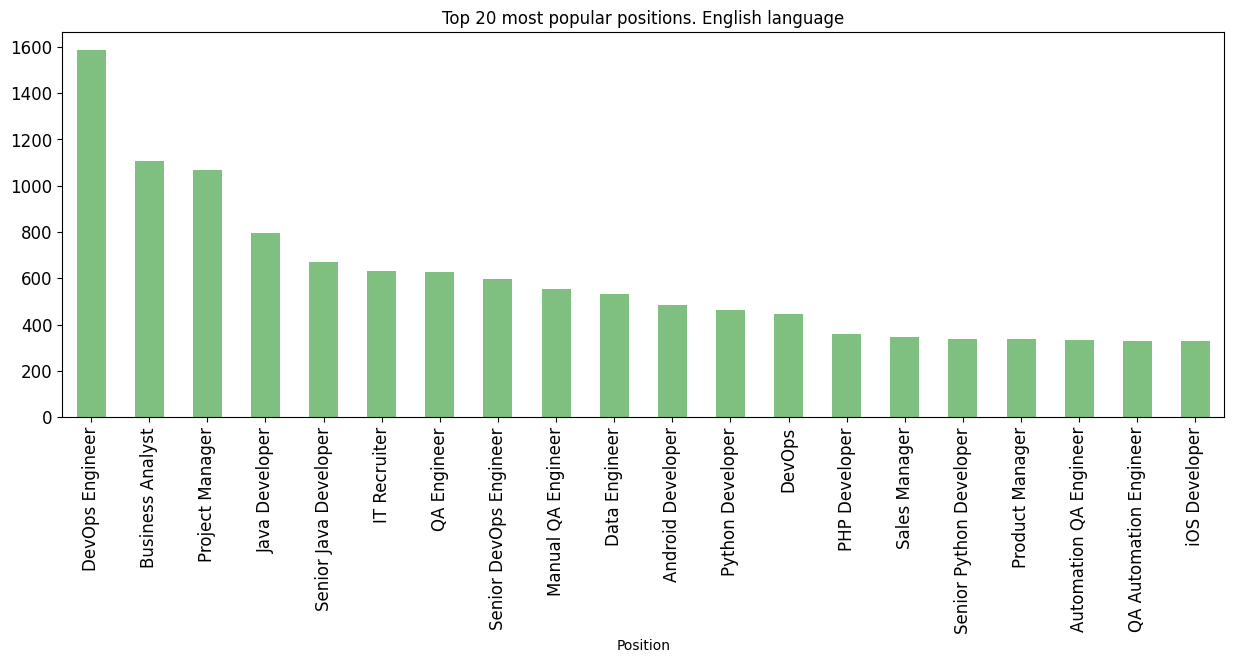

In [11]:
# top 20 most popular positions as a bar chart and show count of each position. English version
df[df['Long Description_lang']=='en']['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions. English language', 
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular positions. Ukrainian language'}, xlabel='Position'>

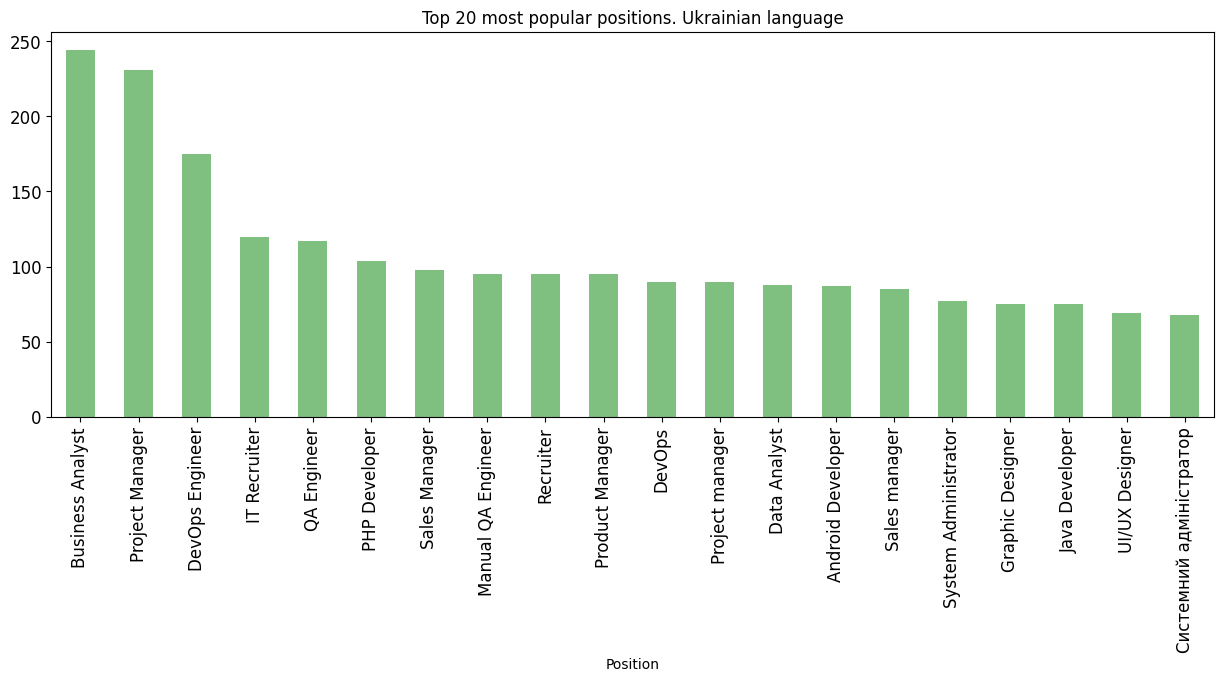

In [12]:
# top 20 most popular positions as a bar chart and show count of each position. English version
df[df['Long Description_lang']=='uk']['Position'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular positions. Ukrainian language', 
                                        fontsize=12, color='green', alpha=0.5)

### Long Description column
`manual written job description`

In [13]:
# Long Description column length statistics
df['Long Description'].str.len().describe()

count    169358.000000
mean       1784.491019
std         970.221067
min          51.000000
25%        1097.000000
50%        1609.000000
75%        2266.000000
max       12578.000000
Name: Long Description, dtype: float64

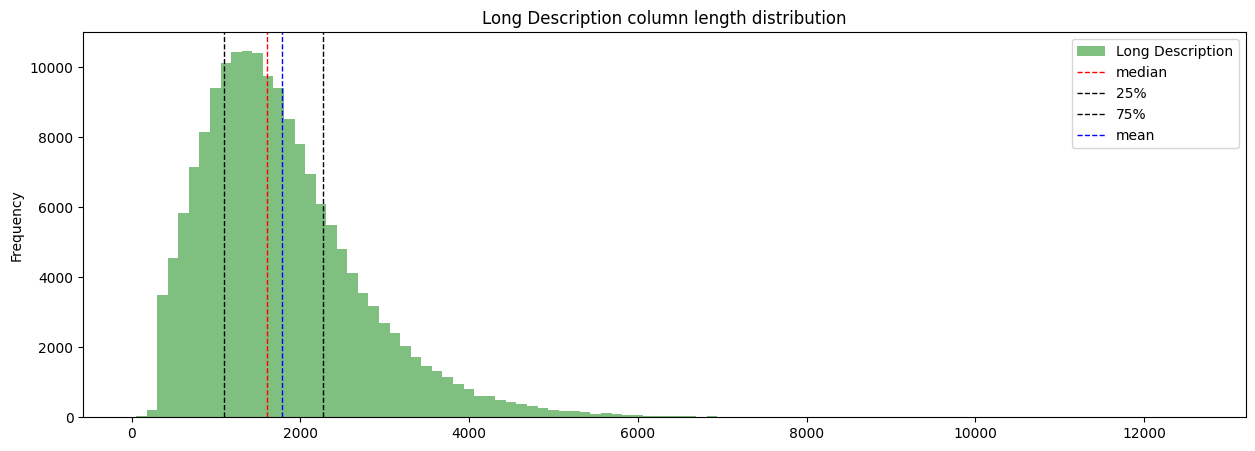

In [14]:
# distribution of Long Description column length
hist_with_stat_line(df, 'Long Description', 'Long Description column length distribution')

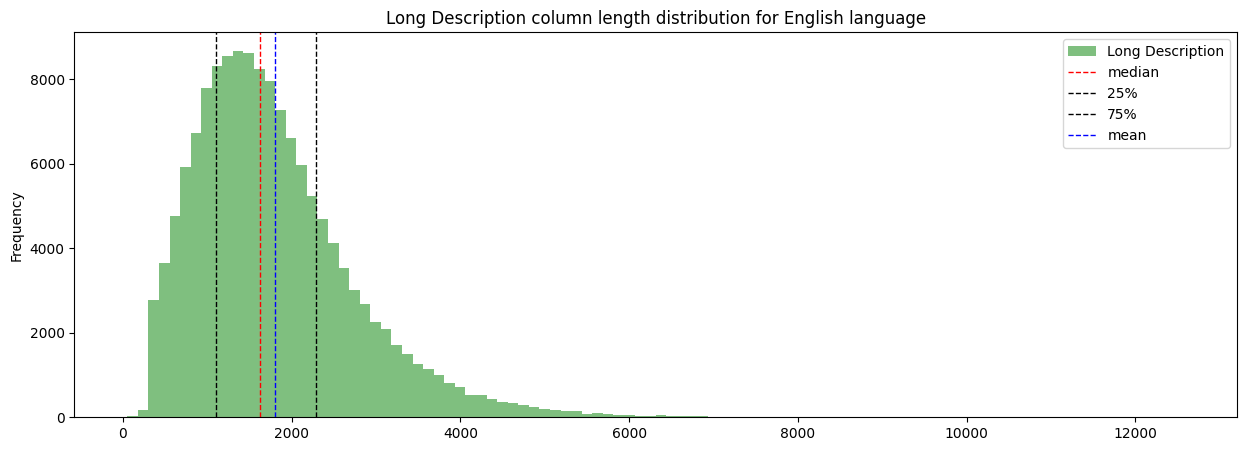

In [15]:
# distribution of Long Description column length for English language
hist_with_stat_line(df[df['Long Description_lang']=='en'], 'Long Description', 'Long Description column length distribution for English language')

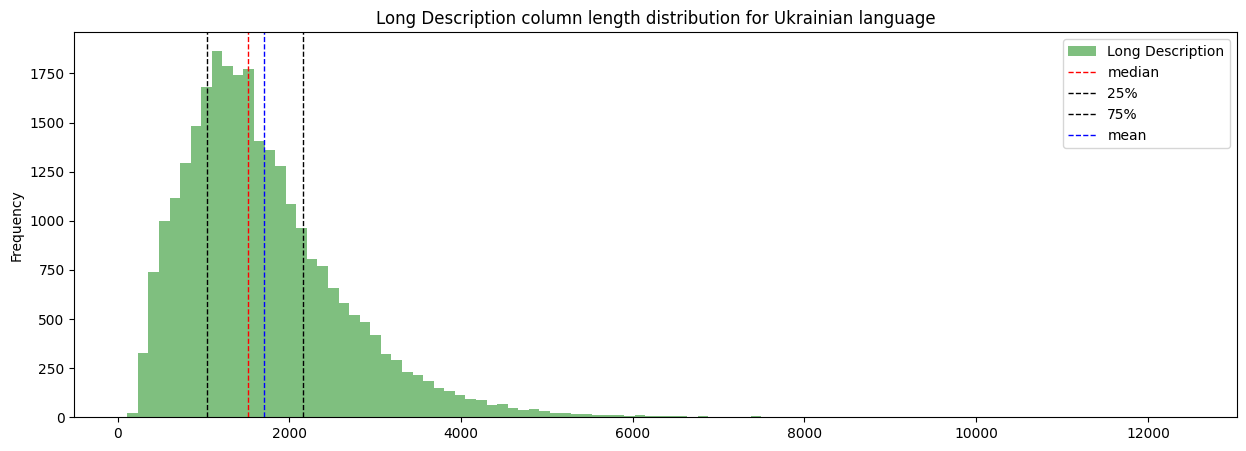

In [16]:
# distribution of Long Description column length for Ukrainian language
hist_with_stat_line(df[df['Long Description_lang']=='uk'], 'Long Description', 'Long Description column length distribution for Ukrainian language')

### Company Name
`company name which hires`

In [17]:
# min, max, mean, median, 25%, 50%, 75% for length of Company Name column
df['Company Name'].str.len().describe()

count    169358.000000
mean         10.236405
std           5.097893
min           2.000000
25%           7.000000
50%           9.000000
75%          12.000000
max          72.000000
Name: Company Name, dtype: float64

<Axes: title={'center': 'Top 20 companies that hire the most'}, xlabel='Company Name'>

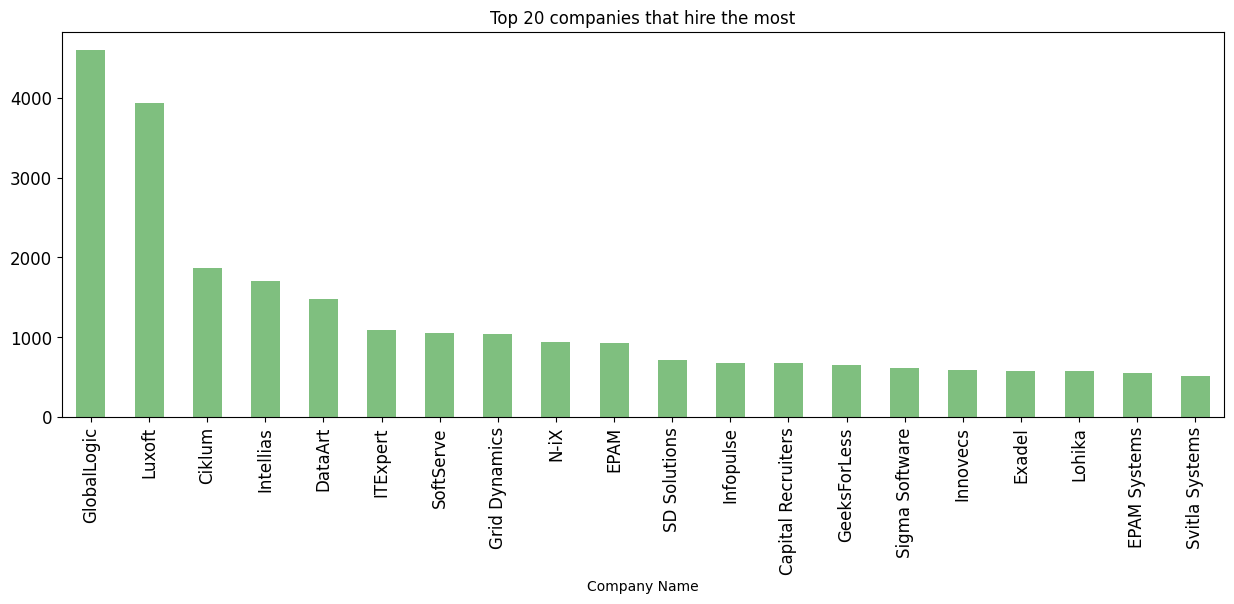

In [18]:
# top 20 most companies that hire the most as a bar chart
df['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 companies that hire the most', 
                                        fontsize=12, color='green', alpha=0.5)

In [19]:
# tail 20 companies that hire
df['Company Name'].value_counts()[-20:]

Company Name
Garment                    1
JustSoftLab                1
B-EE                       1
Protection and Security    1
GSM-Travel                 1
Team Trendformer           1
Hugen ins.                 1
Luna Egde                  1
MaybeWorks                 1
DevCats                    1
Kurkul.com                 1
a stealth startup          1
Nikitin Team               1
Craftera Digital           1
Boostbase Group            1
Bardeen.ai                 1
LLC Vector Incorporated    1
Leads do it                1
Profit Center              1
Titan Systems              1
Name: count, dtype: int64

<Axes: xlabel='Published_year', ylabel='Company Name'>

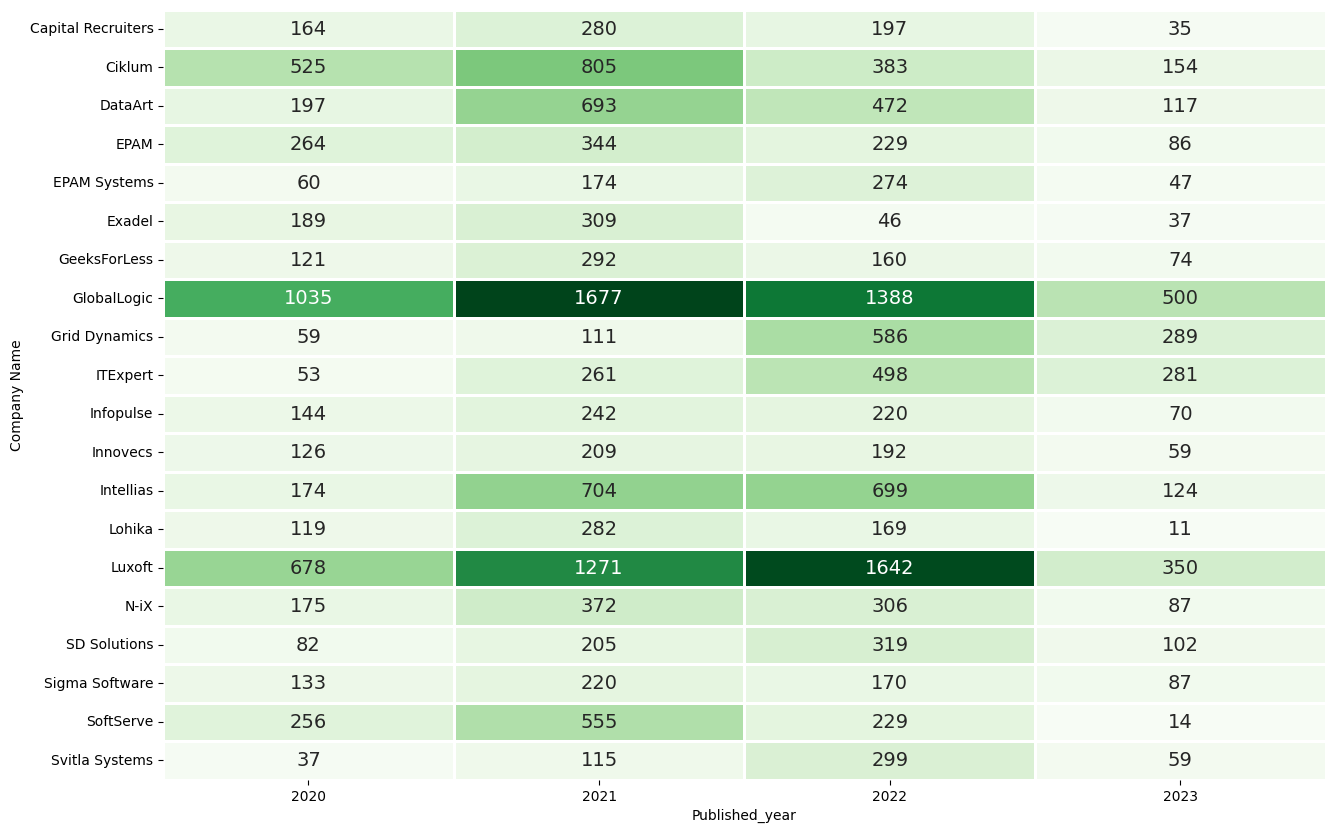

In [20]:
# number of vacancies for top 20 companices per year (Published(str) need to extract year) as headmap
df['Published_year'] = df['Published'].apply(lambda x: int(re.findall(r'\d{4}', x)[0]))

plt.figure(figsize=(15,10))
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:20].index)].pivot_table(index='Company Name', columns='Published_year', values='id', aggfunc='count'), 
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})

<Axes: title={'center': 'Top 20 most popular companies. English language'}, xlabel='Company Name'>

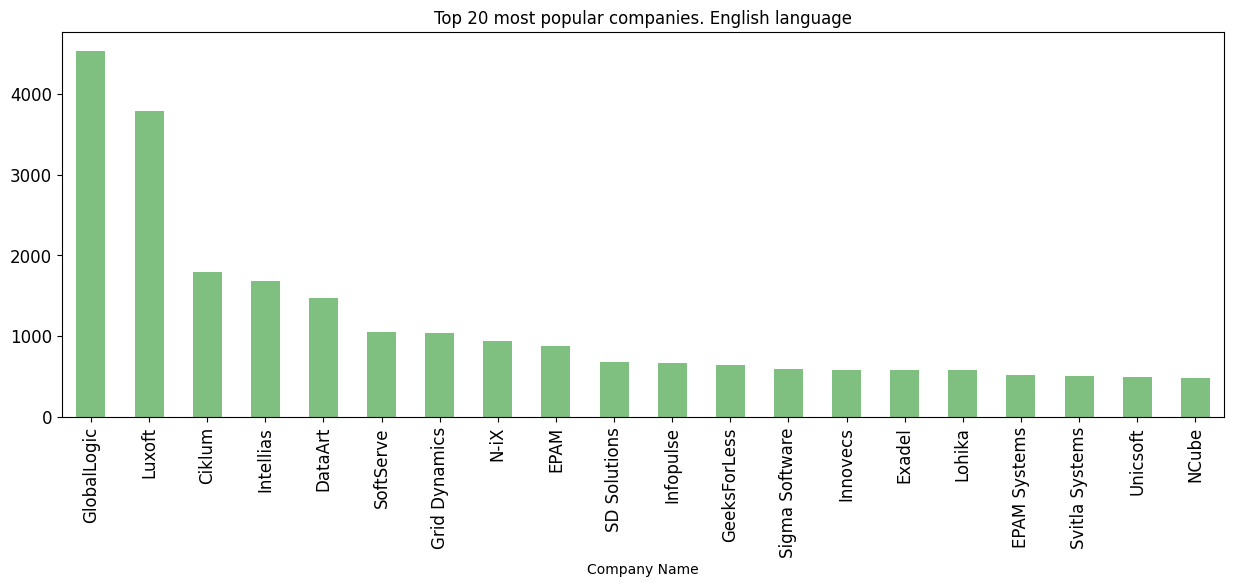

In [21]:
# top 20 most popular companies as a bar chart and show count of each company. English version
df[df['Long Description_lang']=='en']['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular companies. English language', 
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular companies. Ukrainian language'}, xlabel='Company Name'>

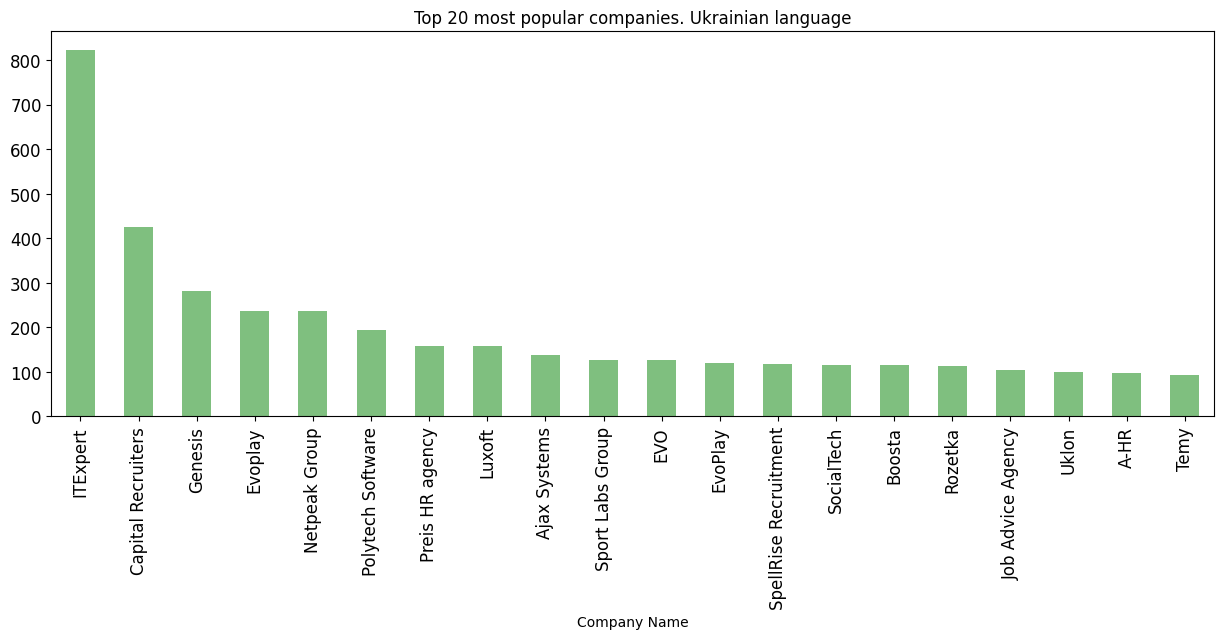

In [22]:
# top 20 most popular companies as a bar chart and show count of each company. Ukrainian version
df[df['Long Description_lang']=='uk']['Company Name'].value_counts()[:20].plot(kind='bar', 
                                        figsize=(15,5), title='Top 20 most popular companies. Ukrainian language', 
                                        fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 10 companies to top 10 positions')

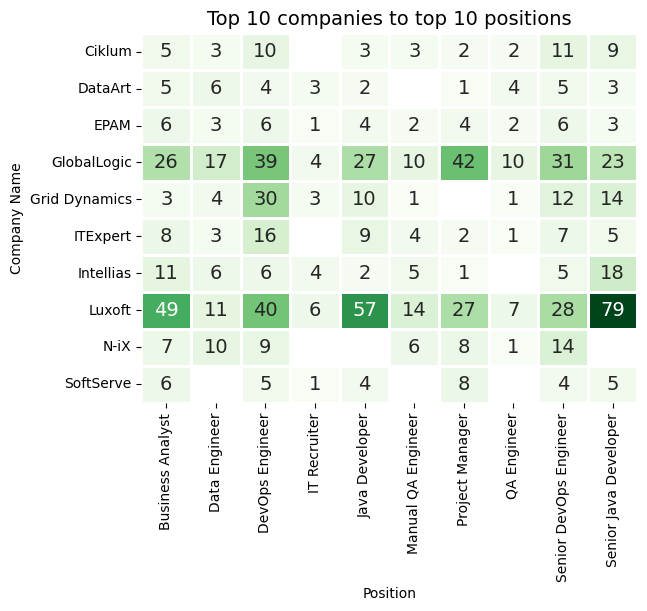

In [23]:
# top 10 companies to top 10 positions as matrix
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:10].index) & df['Position'].isin(df['Position'].value_counts()[:10].index)].pivot_table(index='Company Name', columns='Position', values='id', aggfunc='count'),
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})
plt.title('Top 10 companies to top 10 positions', fontsize=14)

### Exp Years
`experience years required`

In [24]:
df['Exp Years'].unique()

array(['2y', '3y', 'no_exp', '5y', '1y'], dtype=object)

In [25]:
# transform Exp Years column to numeric
map_exp =  {
    "3y": 3,
    "1y": 1,
    "2y": 2,
    "5y": 5,
    "no_exp": 0,
}
df['Exp Years'] = df['Exp Years'].map(map_exp)

In [26]:
# general statistics for Experience Years column
df['Exp Years'].describe()

count    169358.000000
mean          2.582866
std           1.395998
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: Exp Years, dtype: float64

<Axes: title={'center': 'Experience Years count'}, xlabel='Exp Years'>

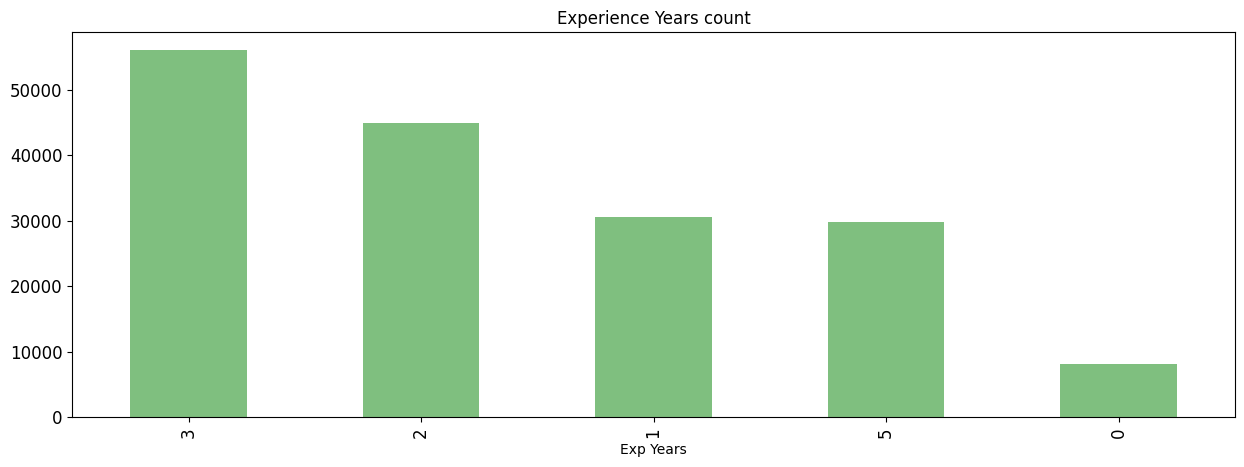

In [27]:
# bar chart for Experience Years column
df['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Experience Years count. English language'}, xlabel='Exp Years'>

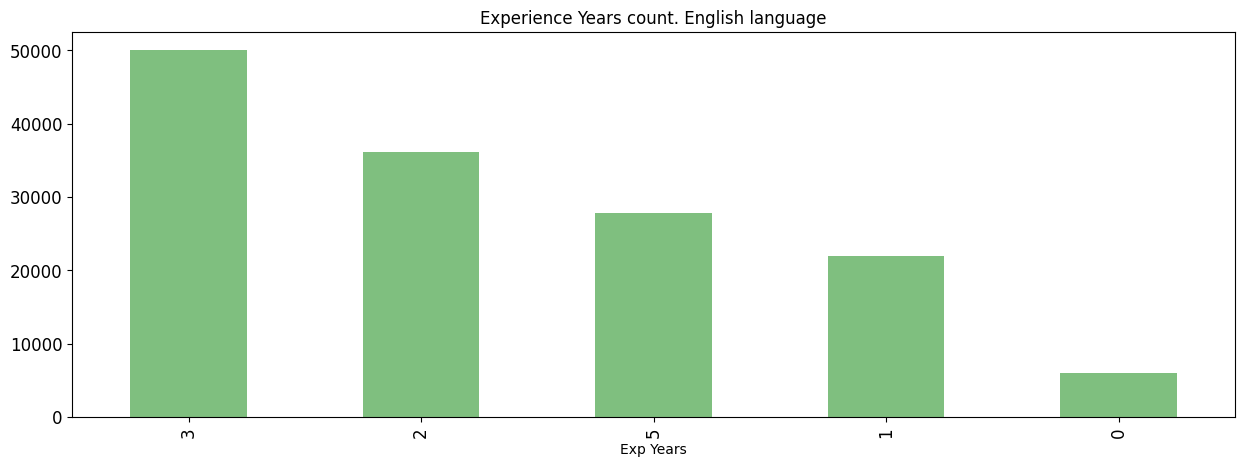

In [28]:
# bar chart for Experience Years column for English language
df[df['Long Description_lang']=='en']['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count. English language',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Experience Years count. Ukrainian language'}, xlabel='Exp Years'>

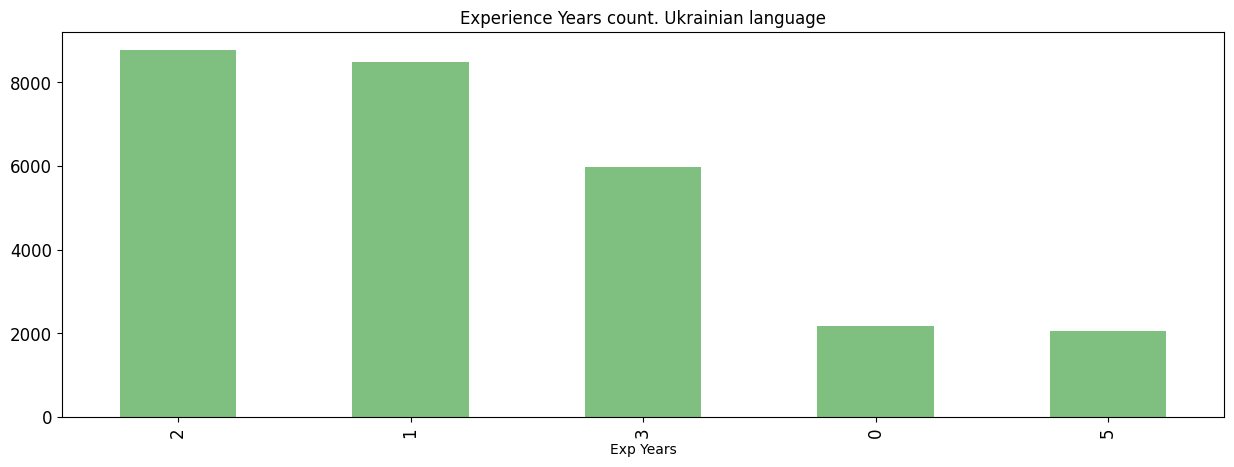

In [29]:
# bar chart for Experience Years column for Ukrainian language
df[df['Long Description_lang']=='uk']['Exp Years'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Experience Years count. Ukrainian language',
                                            fontsize=12, color='green', alpha=0.5)

### Primary Keyword
`job profile type`

In [30]:
# unique Primary Keyword count
print("Unique Primary Keyword count:",len(df['Primary Keyword'].unique()))

Unique Primary Keyword count: 46


<Axes: title={'center': 'Top 20 most popular Primary Keywords'}, xlabel='Primary Keyword'>

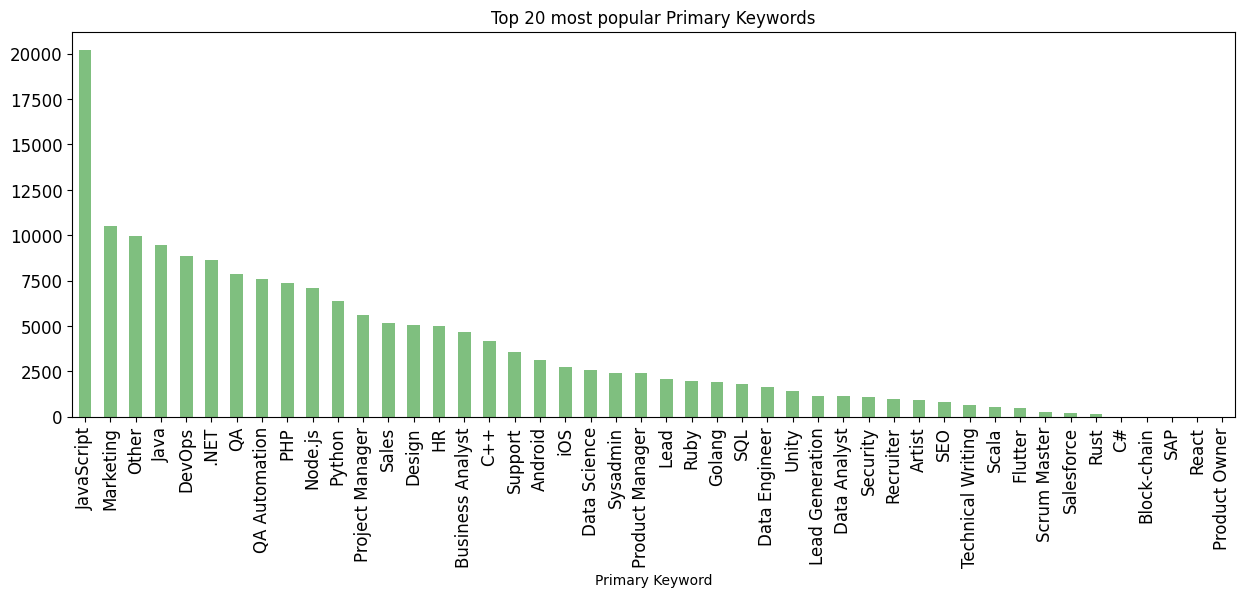

In [31]:
# primary keyword bar chart
df['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular Primary Keywords. English language'}, xlabel='Primary Keyword'>

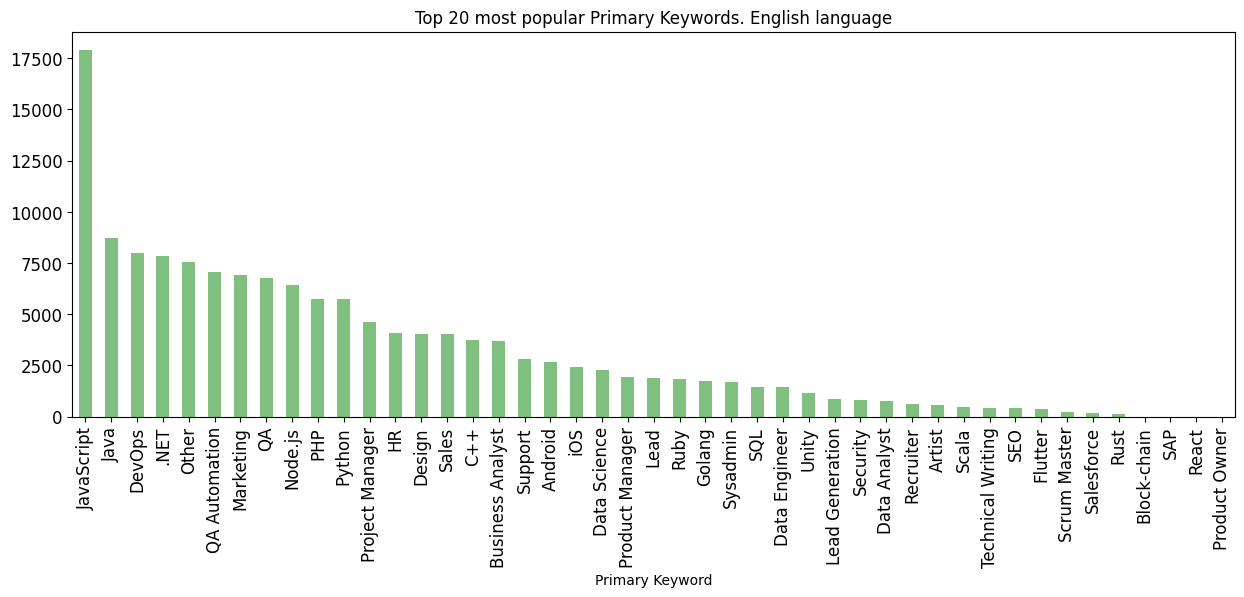

In [32]:
# primary keyword bar chart for English language
df[df['Long Description_lang']=='en']['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords. English language',
                                            fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'Top 20 most popular Primary Keywords. Ukrainian language'}, xlabel='Primary Keyword'>

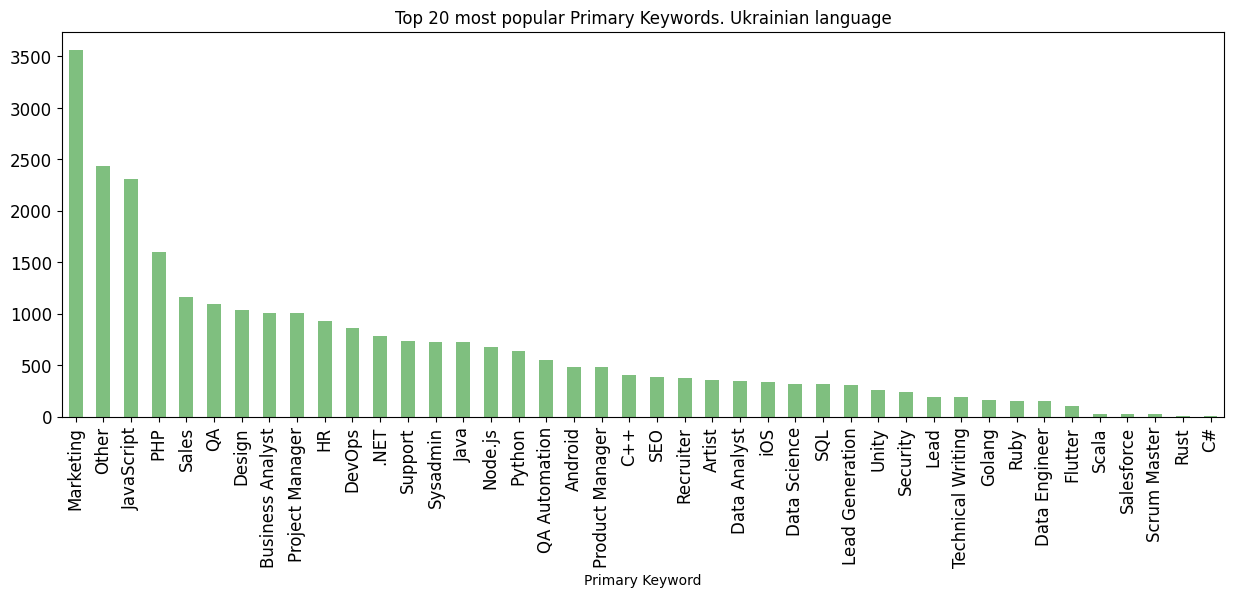

In [33]:
# primary keyword bar chart for Ukrainian language
df[df['Long Description_lang']=='uk']['Primary Keyword'].value_counts().plot(kind='bar',
                                            figsize=(15,5), title='Top 20 most popular Primary Keywords. Ukrainian language',
                                            fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 10 companies to top 10 Primary Keyword')

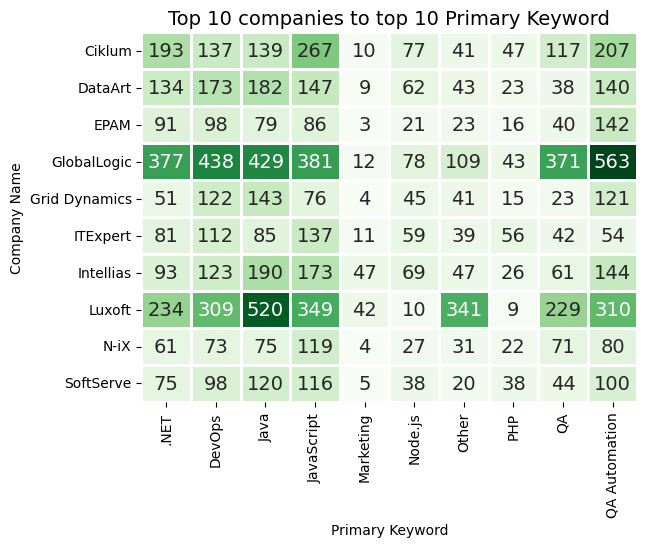

In [34]:
# top 10 companies to top 10 Primary Keyword as matrix
sns.heatmap(df[df['Company Name'].isin(df['Company Name'].value_counts()[:10].index) & df['Primary Keyword'].isin(df['Primary Keyword'].value_counts()[:10].index)].pivot_table(index='Company Name', 
                                                                                                                                                                                columns='Primary Keyword', values='id', aggfunc='count'),
            cmap='Greens', annot=True, fmt='.0f', linewidths=.8, cbar=False, annot_kws={"size": 14})
plt.title('Top 10 companies to top 10 Primary Keyword', fontsize=14)

# English Level
`english level required`

In [35]:
# unique English Level count
print("Unique English Level count:",len(df['English Level'].unique()))

Unique English Level count: 6


<Axes: title={'center': 'English Level count'}, xlabel='English Level'>

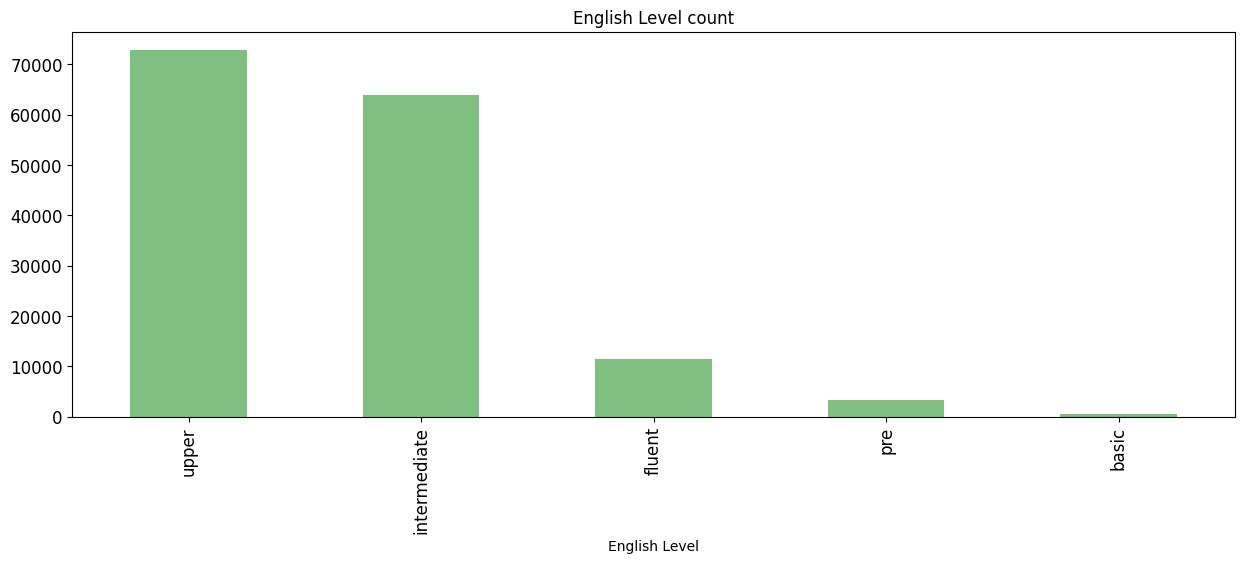

In [36]:
# English Level bar chart
df['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count',
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'English Level count. English language'}, xlabel='English Level'>

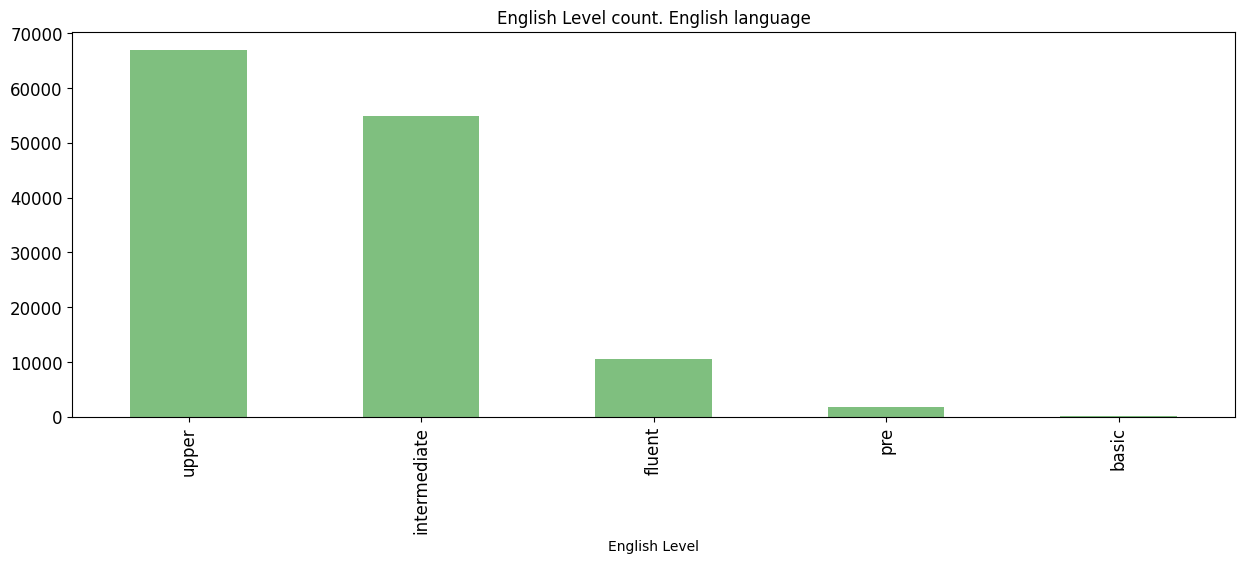

In [37]:
# English Level bar chart for English language
df[df['Long Description_lang']=='en']['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count. English language',
                                        fontsize=12, color='green', alpha=0.5)

<Axes: title={'center': 'English Level count. Ukrainian language'}, xlabel='English Level'>

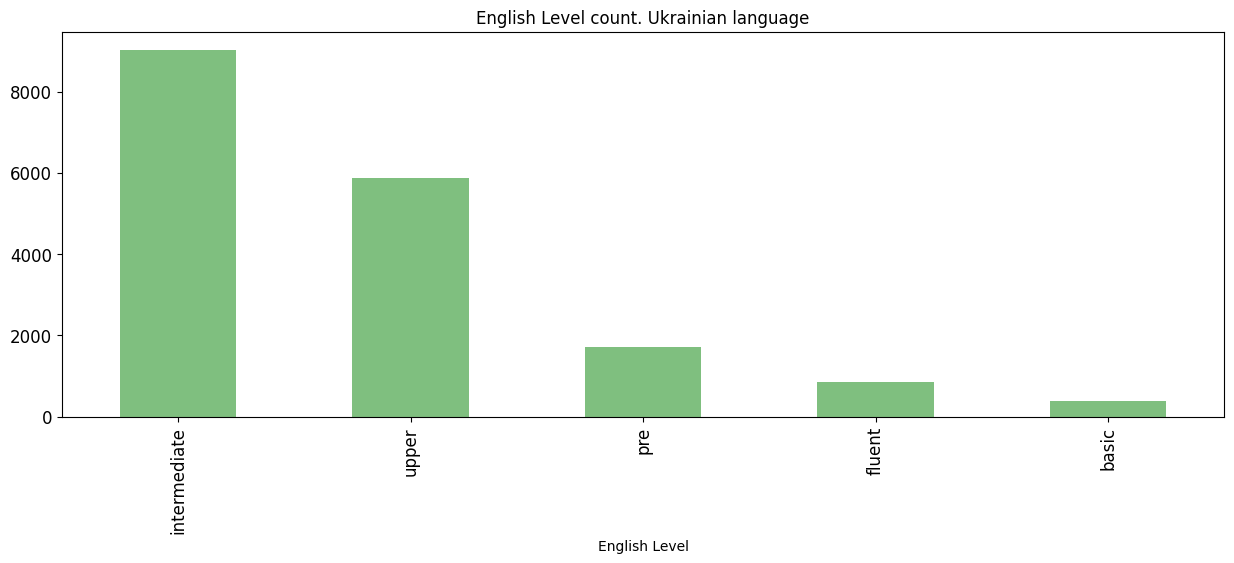

In [38]:
# English Level bar chart for Ukrainian language
df[df['Long Description_lang']=='uk']['English Level'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='English Level count. Ukrainian language',
                                        fontsize=12, color='green', alpha=0.5)

## Published
`date of publishing`

<Axes: title={'center': 'Year of publication count'}, xlabel='Published_year'>

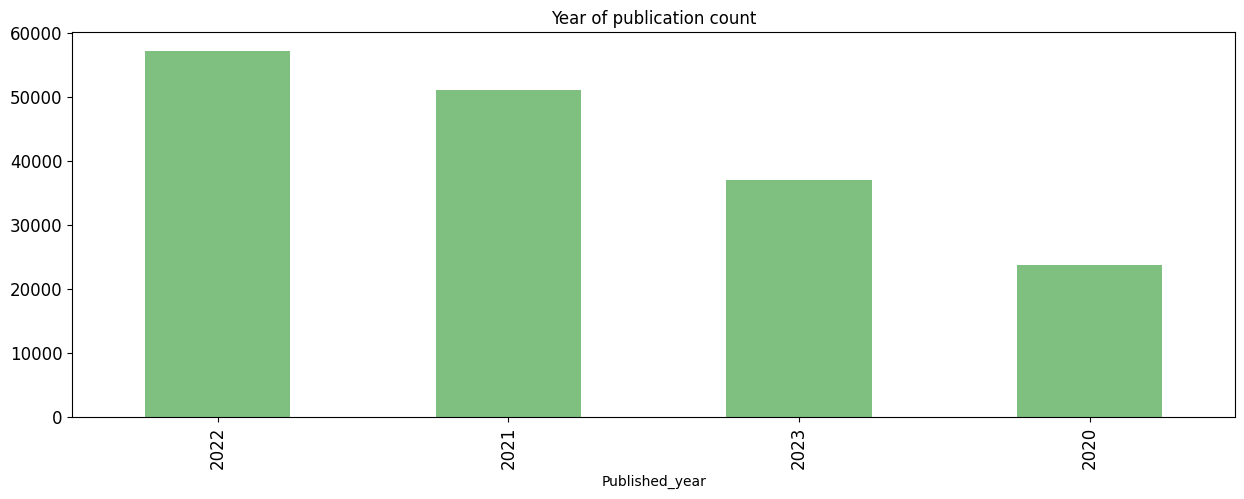

In [39]:
# year of publication bar chart
df['Published_year'] = df['Published'].apply(lambda x: int(re.findall(r'\d{4}', x)[0]))
df['Published_year'].value_counts().plot(kind='bar',
                                        figsize=(15,5), title='Year of publication count',
                                        fontsize=12, color='green', alpha=0.5)

Text(0.5, 1.0, 'Top 20 most popular positions per year')

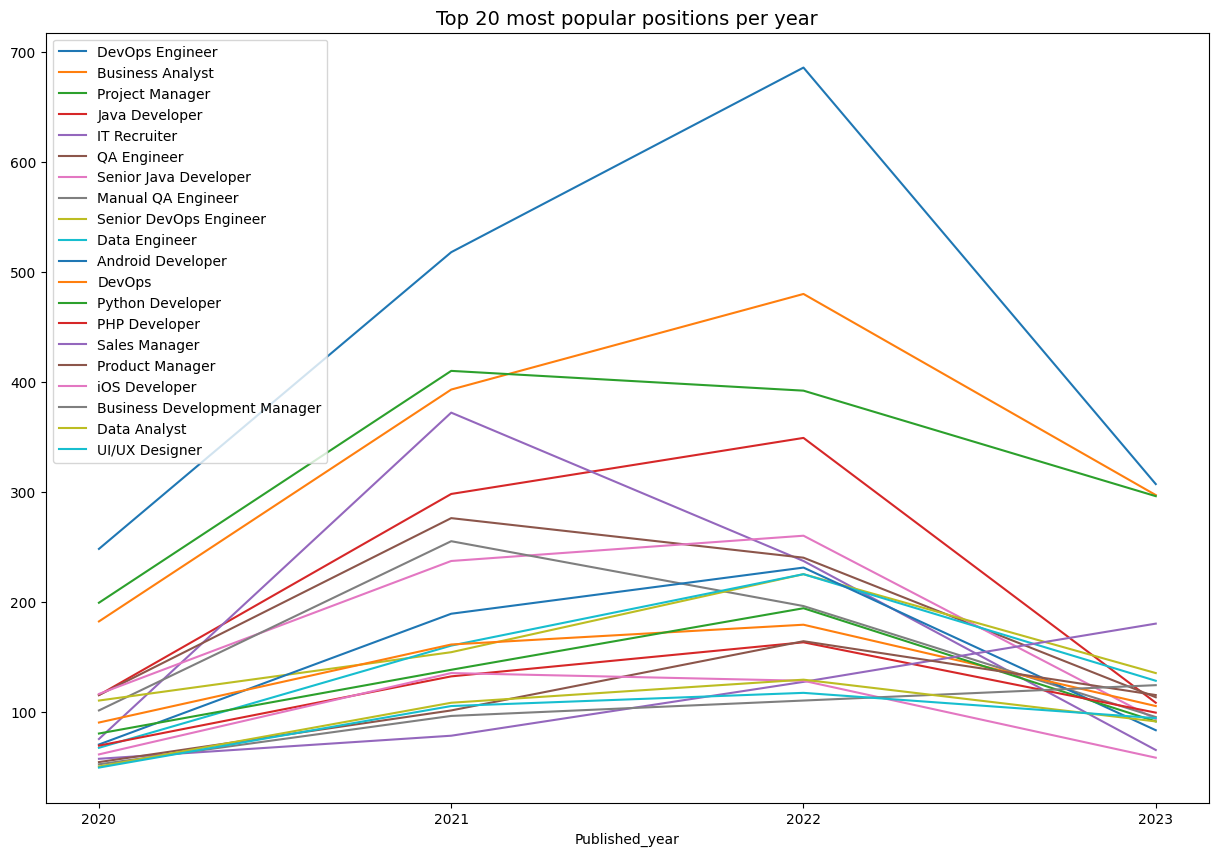

In [40]:
# line plot of top 20 most popular positions per year
plt.figure(figsize=(15,10))
for pos in df['Position'].value_counts()[:20].index:
    df[df['Position']==pos]['Published_year'].value_counts().sort_index().plot(kind='line', label=pos)
plt.legend()
plt.xticks([2020, 2021,2022,2023])
plt.title('Top 20 most popular positions per year', fontsize=14)


### Long Description_lang
`syntetic created column from Long Description column for language detection`

In [43]:
df['Long Description_lang'].value_counts()

Long Description_lang
en    141897
uk     27461
Name: count, dtype: int64

<Axes: title={'center': 'Long Description_lang column value counts'}, ylabel='count'>

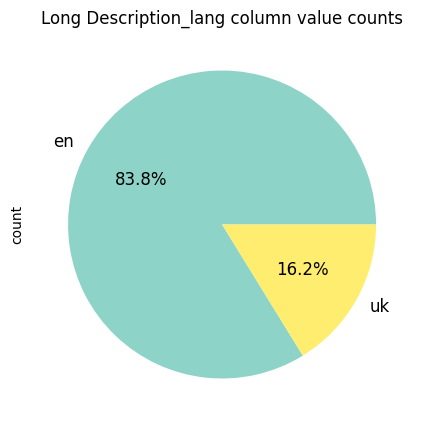

In [41]:
# Long Description_lang column value counts as a pie chart
df['Long Description_lang'].value_counts().plot(kind='pie', figsize=(5,5), title='Long Description_lang column value counts', fontsize=12, autopct='%1.1f%%', colormap='Set3')

### id column
`synthetic created column for identifcation each job`

## Morphological analysis of Job Descriptions

In [42]:
# detect percantage where we have feminitive in Ukrainian Long Descriptions

morph = pymorphy3.MorphAnalyzer(lang='uk')

def detect_feminitive(text):
    words = tokenize_uk.tokenize_uk.tokenize_words(text)
    verbs = [morph.parse(word)[0].word for word in words if morph.parse(word)[0].tag.POS == 'VERB']
    femn_verb_len = len([morph.parse(word)[0].tag.gender for word in verbs if morph.parse(word)[0].tag.gender == 'femn'])
    if femn_verb_len == 0 or len(verbs) == 0:
        return 0
    
    gender = femn_verb_len/len(verbs)
    return 1 if gender > 0.5 else 0

count = 0
ukr_cv = df[df['Long Description_lang'] == 'uk']['Long Description'].values
for cv_text in tqdm(ukr_cv):
    count+=detect_feminitive(cv_text)
print("Percentage of feminitive in Ukrainian CVs:", count/len(ukr_cv))

  4%|‚ñç         | 1222/27461 [00:17<06:15, 69.83it/s] 


KeyboardInterrupt: 

## Protected groups detect by languages(other than gender)

In [44]:
def protected_groups_uk(values:list[str]):
    marital_count = 0
    military_count = 0
    religion_count = 0
    age_count = 0
    marital_detect_exp = []
    military_detect_exp = []
    religion_detect_exp = []
    age_detect_exp = []
    for val in values:
        if re.search(r'—Å—ñ–º–µ–π–Ω–∏–π —Å—Ç–∞—Ç—É—Å', val) or re.search(r'–∑–∞–º—ñ–∂–Ω', val) or re.search(r'–æ–¥—Ä—É–∂–µ–Ω', val):
            marital_count+=1
            marital_detect_exp.append(val)
        if re.search(r'–≤—ñ–π—Å—å–∫–æ–≤', val) or re.search(r'–≤—ñ–π—Å—å–∫', val):
            military_count+=1
            military_detect_exp.append(val)
        if re.search(r'—Ä–µ–ª—ñ–≥—ñ—è', val):
            religion_count+=1
            religion_detect_exp.append(val)
        if re.search(r'–≤—ñ–∫', val):
            age_count+=1
            age_detect_exp.append(val)

    print("Marital status count:", marital_count)
    print("Marital status:", marital_count/len(values))
    print("EXAMPLES:")
    for exp in marital_detect_exp[:5]:
        print(exp)
        print()
    print("\nMilitary status count:", military_count)
    print("Military status:", military_count/len(values))
    print("EXAMPLES:")
    for exp in military_detect_exp[:5]:
        print(exp)
        print()
    print("\nReligion status count:", religion_count)
    print("Religion status:", religion_count/len(values))
    print("EXAMPLES:")
    for exp in religion_detect_exp[:5]:
        print(exp)
        print()
    print("\nAge status count:", age_count)
    print("Age status:", age_count/len(values))
    print("EXAMPLES:")
    for exp in age_detect_exp[:5]:
        print(exp)
        print()
        
    
def protected_groups_en(values:list[str]):
    marital_count = 0
    military_count = 0
    religion_count = 0
    age_count = 0
    marital_detect_exp = []
    military_detect_exp = []
    religion_detect_exp = []
    age_detect_exp = []
    for val in values:
        if re.search(r'marital status', val) or re.search(r'married', val):
            marital_count+=1
            marital_detect_exp.append(val)
        if re.search(r'military', val):
            military_count+=1
            military_detect_exp.append(val)
        if re.search(r'religion', val):
            religion_count+=1
            religion_detect_exp.append(val)
        if re.search(r'candidate age', val.lower()):
            age_count+=1
            age_detect_exp.append(val)

    print("Marital status count:", marital_count)
    print("Marital status:", marital_count/len(values))
    print("EXAMPLES:")
    for exp in marital_detect_exp[:5]:
        print(exp)
        print()
    print("\nMilitary status count:", military_count)
    print("Military status:", military_count/len(values))
    print("EXAMPLES:")
    for exp in military_detect_exp[:5]:
        print(exp)
        print()
    print("\nReligion status count:", religion_count)
    print("Religion status:", religion_count/len(values))
    print("EXAMPLES:")
    for exp in religion_detect_exp[:5]:
        print(exp)
        print()
    print("\nAge status count:", age_count)
    print("Age status:", age_count/len(values))
    print("EXAMPLES:")
    for exp in age_detect_exp[:5]:
        print(exp)
        print()

print("Ukrainian Long Description:")
protected_groups_uk(df[df['Long Description_lang'] == 'uk']['Long Description'].values)
print("\nEnglish  Long Description::")
protected_groups_en(df[df['Long Description_lang'] == 'en']['Long Description'].values)

Ukrainian Long Description:
Marital status count: 2
Marital status: 0.002178649237472767
EXAMPLES:
**–û–±–æ–≤‚Äô—è–∑–∫–∏: **
–†–æ–∑—Ä–æ–±–ª—è—Ç–∏ –≤–µ–±-—Å–∞–π—Ç–∏ WordPress –∑ –Ω—É–ª—è 
–†–æ–∑—Ä–æ–±–ª—è—Ç–∏ –≤–µ–±-—Å–∞–π—Ç–∏ WordPress –Ω–∞ –æ—Å–Ω–æ–≤—ñ —Ç–µ–º 
–ù–∞–¥–∞–≤–∞—Ç–∏ –æ–±“ë—Ä—É–Ω—Ç–æ–≤–∞–Ω—ñ —Ç–∞ —Ç–æ—á–Ω—ñ –æ—Ü—ñ–Ω–∫–∏ —á–∞—Å—É –¥–ª—è –≤–∏–∫–æ–Ω–∞–Ω–Ω—è –∑–∞–≤–¥–∞–Ω—å —Ç–∞ –¥–æ—Ç—Ä–∏–º—É–≤–∞—Ç–∏—Å—å –∑–∞–∑–Ω–∞—á–µ–Ω–∏—Ö —Ç–µ—Ä–º—ñ–Ω—ñ–≤ 
–ë—Ä–∞—Ç–∏ —É—á–∞—Å—Ç—å —É Code Review
–ü—ñ–¥—Ç—Ä–∏–º—É–≤–∞—Ç–∏ —ñ—Å–Ω—É—é—á—ñ –≤–µ–±-—Å–∞–π—Ç–∏ WordPress 
–ë—Ä–∞—Ç–∏ —É—á–∞—Å—Ç—å –≤ –æ—Ü—ñ–Ω—Ü—ñ —ñ –ø–ª–∞–Ω—É–≤–∞–Ω–Ω—ñ 

**–í–∏–º–æ–≥–∏: **
1+ —Ä—ñ–∫ –¥–æ—Å–≤—ñ–¥—É —Ä–æ–±–æ—Ç–∏ –∑ WordPress
–ó–Ω–∞–Ω–Ω—è HTML —ñ CSS 
–ó–Ω–∞–Ω–Ω—è JavaScript / jQuery 
–ó–Ω–∞–Ω–Ω—è PHP 
–î–æ—Å–≤—ñ–¥ —Ä–æ–±–æ—Ç–∏ –∑ ACF 
–î–æ—Å–≤—ñ–¥ —Ä–æ–±–æ—Ç–∏ –∑ Photoshop / Figma / AdobeXD 
–†–æ–∑—É–º—ñ–Ω–Ω—è —Ä–æ–±–æ—á–æ–≥–æ –ø—Ä–æ—Ü–µ—Å—É Git 

**–©–æ –º–∏ –ø—Ä–æ–ø–æ–Ω—É—î–º–æ?**
–ö–æ–º–∞–Ω–¥–∞ –º–∞—î –¥–ª—è –Ω–∞—Å –≤–

After simple analyses of detecting protected groups in Job Description, we can tell that there are no protected groups in the job descriptions, all findings are false positives.

## Manual check of data sample(10 samples English language)

In [45]:
for text in df[df['Long Description_lang']=='en'].sample(10)['Long Description']:
    print(text)
    print('-'*100, '\n\n')

**Requirements:**
‚Ä¢ 0,5+ years of experience in recruiting for technical vacancies;
‚Ä¢ Proven work experience as a Talent Sourcer or similar role in IT sphere;
‚Ä¢ Hands-on experience with sourcing techniques (e.g. recruiting on social platforms and crafting Boolean search strings);
‚Ä¢ Familiarity with HR databases, Applicant Tracking Systems (ATSs) and  Candidate Management Systems (CMSs);
‚Ä¢ Solid verbal and written communication skills;
‚Ä¢ Excellent negotiation skills;
‚Ä¢ Ability to positively present our company and open roles to potential candidates;
‚Ä¢ Effective time-management abilities;

**Responsibilities:**
‚Ä¢ Interact with potential candidates on social media and professional networks (e.g. LinkedIn, Github, Djinni)
‚Ä¢ Craft and send recruiting emails
‚Ä¢ Coordinate with hiring managers to determine position requirements
‚Ä¢ Manage candidate interview schedule with HR
‚Ä¢ Identify qualified candidate profiles using various sourcing techniques (e.g. Boolean search)


## Manual check of data sample(10 samples Ukrainian language)

In [46]:
for text in df[df['Long Description_lang']=='uk'].sample(10)['Long Description']:
    print(text)
    print('-'*100, '\n\n')

**–¶—ñ–Ω–Ω–æ—Å—Ç—ñ –∫–æ–º–ø–∞–Ω—ñ—ó:** —á–µ—Å–Ω—ñ—Å—Ç—å —Ç–∞ –≤—ñ–¥–∫—Ä–∏—Ç—ñ—Å—Ç—å, –∫–æ–º—É–Ω—ñ–∫–∞—Ü—ñ—è, –ø—Ä–æ—Ñ–µ—Å—ñ–æ–Ω–∞–ª—ñ–∑–º —Ç–∞ –Ω–æ–≤–∞—Ç–æ—Ä—Å—Ç–≤–æ. 
–ú–∏ –Ω–∞–º–∞–≥–∞—î–º–æ—Å—å —Ä–æ–±–∏—Ç–∏ –≤—Å–µ, —â–æ–± —Ü—ñ –ø—Ä–∏–Ω—Ü–∏–ø–∏ –±—É–ª–∏ –Ω–µ –ø—Ä–æ—Å—Ç–æ —Å–ª–æ–≤–∞–º–∏, –∞ –≤—ñ–¥—á—É–≤–∞–ª–∏—Å—å –≤ —Ä–æ–±–æ—Ç—ñ –∫–æ–∂–µ–Ω –¥–µ–Ω—å.

–®—É–∫–∞—î–º–æ –≤ –∫–æ–º–∞–Ω–¥—É —Å—Ç–∞—Ä–∞–Ω–Ω–æ–≥–æ —Ç–∞ –≤—ñ–¥–ø–æ–≤—ñ–¥–∞–ª—å–Ω–æ–≥–æ **Junior QA Engineer**! –ì–æ—Ç–æ–≤—ñ –Ω–∞–≤—á–∞—Ç–∏ —Ç–∞ –¥–æ–ø–æ–º–∞–≥–∞—Ç–∏. –Ø–∫—â–æ —Ç–∏ –º—Ä—ñ—î—à –ø—Ä–æ —Ü—ñ–∫–∞–≤–∏–π –¥–æ—Å–≤—ñ–¥ —Ä–æ–±–æ—Ç–∏ —Ç–∞ –Ω–æ–≤—ñ –∑–Ω–∞–Ω–Ω—è –Ω–∞ –ø–æ–∑–∏—Ü—ñ—ó QA Engineer - —Ç–æ–¥—ñ –º–∏ —á–µ–∫–∞—î–º–æ —Å–∞–º–µ –Ω–∞ —Ç–µ–±–µ!


**–†–æ–∑–ø–æ–≤—ñ–¥–∞—é —Ç–æ–±—ñ, —á–∏–º —Ç–∏ –±—É–¥–µ—à –∑–∞–π–º–∞—Ç–∏—Å—å:**
- –¢–µ—Å—Ç—É–≤–∞–Ω–Ω—è–º –Ω–æ–≤–æ–≥–æ —Ç–∞ –ø–æ—Ç–æ—á–Ω–æ–≥–æ —Ñ—É–Ω–∫—Ü—ñ–æ–Ω–∞–ª—É;
- –í–µ–¥–µ–Ω–Ω—è–º —Ç–µ—Å—Ç–æ–≤–æ—ó –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ü—ñ—ó ( –Ω–∞–ø–∏—Å–∞–Ω–Ω—è —Ç–µ—Å—Ç-–∫–µ–π—Å—ñ–≤ —Ç–∞ —á–µ–∫-–ª–∏—Å—Ç—